In [1]:
using Plots

# Parameters
γ = 1.4  # Adiabatic index for relativistic gas 5/3 , 4/3 , 1.999
c = 1.0  # Speed of light (set to 1 for simplicity)
N = 200  # Number of grid points
L = 1.0  # Domain length
L_mid = L / 2

N_mid = N / 2
dx = L / N  # Grid spacing
dt = 0.001  # Time step
T = 0.25  # Total simulation time
CFL = 0.9;  # CFL condition
println(L_mid)
println(N_mid)

0.5
100.0


In [2]:
# Initial condition 
function initial_condition(x)
    if x < L_mid
        ρ =  1.0  # Rest-mass density on the left  1.0, 10.0,2.0
        v =  0.0   # Velocity on the left
        p =  1.0  # Pressure on the left   1.0, 40.0/3 ,1990
    else
        ρ =  0.125  # Rest-mass density on the right 1.0,0.125,1.0
        v =  0.0    # Velocity on the right
        p =  0.1   # Pressure on the right 0.00001*(2/3) , 0.1 , 995
    end
    W = 1 / sqrt(1 - v^2)  # Lorentz factor
    h = 1 + (γ * p) / ((γ - 1) * ρ)  # Specific enthalpy
    D = ρ * W  # Relativistic mass density
    S = ρ * h * W^2 * v  # Momentum density
    E = ρ * h * W^2 - p   # Energy density
    
    if E < D && E < S
        return println("Warning: Physical constraints violated in initial_condition at  x = $x")
    else
        return [D, S, E]
    end
end
x1 = 0.8
print(initial_condition(x1))

[0.125, 0.0, 0.375]

In [3]:
using Roots

function pressure_nu(U)
    D,S,E = U 
    function g(v)
        return ((v * E - S) + (γ - 1) * S * (1 - v^2)*(1 / γ))^2
    end
    vr = find_zero(g, 0.5)
    #range = (0.0, 1.0)  # Search range
    #initial_guess = 0.5
    #vr = find_zero(g, (range[1], range[2], initial_guess))
    e = E - vr*S
    p = (γ - 1)*(E - vr*S) 
    return [p,vr,e]
end

print(pressure_nu(initial_condition(x1)))
pressure_nu(initial_condition(x1))

[0.14999999999999997, 4.986765367498636e-8, 0.375]

3-element Vector{Float64}:
 0.14999999999999997
 4.986765367498636e-8
 0.375

In [4]:
function flux(U)
    D, S, E = U
    p = pressure_nu(U)[1]  # Pressure
    v = pressure_nu(U)[2]
    return [v * D, v * S + p, (p + E) * v]
end

flux(initial_condition(x1))

3-element Vector{Float64}:
 6.233456709373295e-9
 0.14999999999999997
 2.6180518179367836e-8

In [5]:
function relativistic_hlle_flux(U_L,U_R)
    p_L = pressure_nu(U_L)[1]
    p_R = pressure_nu(U_R)[1]
    
    c_s_L = sqrt(γ * p_L / (U_L[1] + (γ/(γ-1))*p_L))
    c_s_R = sqrt(γ * p_R / (U_R[1] + (γ/(γ-1))*p_R))
    
    v_L = pressure_nu(U_L)[2]
    v_R = pressure_nu(U_R)[2]
    
    λ_L = min(0, (v_L - c_s_L) / (1 - v_L * c_s_L), (v_R - c_s_R) / (1 - v_R * c_s_R))
    λ_R = max(0, (v_L + c_s_L) / (1 + v_L * c_s_L), (v_R + c_s_R) / (1 + v_R * c_s_R))
    
    F_L = flux(U_L)
    F_R = flux(U_R)
    
    if λ_L >= 0
        return F_L
    elseif λ_R <= 0
        return F_R
    else
        return (λ_R * F_L - λ_L * F_R + λ_L * λ_R * (U_R - U_L)) / (λ_R - λ_L)
    end
end

relativistic_hlle_flux (generic function with 1 method)

In [6]:
function sound_speed(U_L,U_R)
    p_L = pressure_nu(U_L)[1]
    p_R = pressure_nu(U_R)[1]
    
    c_s_L = sqrt(γ * p_L / (U_L[1] + (γ/(γ-1))*p_L))
    c_s_R = sqrt(γ * p_R / (U_R[1] + (γ/(γ-1))*p_R))
    
    return c_s_L,c_s_R
end

sound_speed (generic function with 1 method)

In [7]:
x = LinRange(0, L, N)
U = [initial_condition(xi) for xi in x]
U_new = deepcopy(U)

200-element Vector{Vector{Float64}}:
 [1.0, 0.0, 3.5]
 [1.0, 0.0, 3.5]
 [1.0, 0.0, 3.5]
 [1.0, 0.0, 3.5]
 [1.0, 0.0, 3.5]
 [1.0, 0.0, 3.5]
 [1.0, 0.0, 3.5]
 [1.0, 0.0, 3.5]
 [1.0, 0.0, 3.5]
 [1.0, 0.0, 3.5]
 [1.0, 0.0, 3.5]
 [1.0, 0.0, 3.5]
 [1.0, 0.0, 3.5]
 ⋮
 [0.125, 0.0, 0.375]
 [0.125, 0.0, 0.375]
 [0.125, 0.0, 0.375]
 [0.125, 0.0, 0.375]
 [0.125, 0.0, 0.375]
 [0.125, 0.0, 0.375]
 [0.125, 0.0, 0.375]
 [0.125, 0.0, 0.375]
 [0.125, 0.0, 0.375]
 [0.125, 0.0, 0.375]
 [0.125, 0.0, 0.375]
 [0.125, 0.0, 0.375]

In [8]:
sound_speed(U[100],U[101])

(0.5763708787148327, 0.5683985600588051)

In [9]:
relativistic_hlle_flux(U[100],U[100 + 1])

3-element Vector{Float64}:
 0.25216226619226395
 0.7750000052685432
 0.9005795289073871

In [10]:
function minmod(a, b)
    if a * b <= 0
        return 0.0
    else
        return sign(a) * min(abs(a), abs(b))
    end
end

minmod (generic function with 1 method)

In [11]:
function minmod_slope_limiter(U)
    NC = length(U) - 2  # Assuming U has ghost cells at boundaries
    UL = similar(U)
    UR = similar(U)

    for j in 2:NC+1  # Adjusting for Julia's 1-based indexing
        Ujm1 = U[j-1]
        Uj   = U[j]
        Ujp1 = U[j+1]

        sp = Ujp1 - Uj
        sm = Uj - Ujm1

        ssp = sign(sp)
        ssm = sign(sm)

        asp = abs(sp)
        asm = abs(sm)

        dU = 0.25 * (ssp + ssm) * min(asp, asm)

        Ujp = Uj + dU
        Ujm = Uj - dU

        UL[j] = Ujp
        UR[j-1] = Ujm
    end

    return UL, UR
end


minmod_slope_limiter (generic function with 1 method)

In [12]:
minmod(U[100][1],U[101][1])

0.125

In [13]:
#H = minmod_slope_limiter(U[1])

In [14]:
#H[1] 

In [15]:
"""
t = 0.0
while t <= T
    for i in 2:N-1
        U_L = U[i]  #U[i-1]
        U_R = U[i+1]
        
        F = relativistic_hlle_flux(U_L, U_R)
        U_new[i] = U[i] - (dt / dx) * (F - relativistic_hlle_flux(U[i-1], U[i]))
    end
    # Apply boundary conditions (transmissive)
    U_new[1] = U_new[2]
    U_new[end] = U_new[end-1]

    # Update solution
    U .= U_new
    t += dt
end
"""


"t = 0.0\nwhile t <= T\n    for i in 2:N-1\n        U_L = U[i]  #U[i-1]\n        U_R = U[i+1]\n        \n        F = relativistic_hlle_flux(U_L, U_R)\n        U_new[i] = U[i] - (dt / dx) * (F - relativistic_hlle_flux(U[i-1], U[i]))\n    end\n    # Apply boundary conditions (transmissive)\n    U_new[1] = U_new[2]\n    U_new[end] = U_new[end-1]\n\n    # Update solution\n    U .= U_new\n    t += dt\nend\n"

In [16]:

# Using Slope Limiter scheme (Minmod)

t = 0.0
while t <= T
    for i in 2:N-2
        
        slope_D_L = minmod((U[i][1] - U[i-1][1]) / dx, (U[i+1][1] - U[i][1]) / dx)
        slope_S_L = minmod((U[i][2] - U[i-1][2]) / dx, (U[i+1][2] - U[i][2]) / dx)
        slope_E_L = minmod((U[i][3] - U[i-1][3]) / dx, (U[i+1][3] - U[i][3]) / dx)

        slope_D_R = minmod((U[i+1][1] - U[i][1]) / dx, (U[i+2][1] - U[i+1][1]) / dx)
        slope_S_R = minmod((U[i+1][2] - U[i][2]) / dx, (U[i+2][2] - U[i+1][2]) / dx)
        slope_E_R = minmod((U[i+1][3] - U[i][3]) / dx, (U[i+2][3] - U[i+1][3]) / dx)



        U_L = [U[i][1] + 0.5 * dx * slope_D_L,
               U[i][2] + 0.5 * dx * slope_S_L,
               U[i][3] + 0.5 * dx * slope_E_L]

        U_R = [U[i+1][1] - 0.5 * dx * slope_D_R,
               U[i+1][2] - 0.5 * dx * slope_S_R,
               U[i+1][3] - 0.5 * dx * slope_E_R]
        
        #U_L = U[i]  #U[i-1]
        #U_R = U[i+1]
        
        F = relativistic_hlle_flux(U_L, U_R)
        U_new[i] = U[i] - (dt / dx) * (F - relativistic_hlle_flux(U[i-1], U[i]))
    end

    # Apply boundary conditions (transmissive)
    U_new[1] = U_new[2]
    U_new[end] = U_new[end-1]

    # Update solution
    U .= U_new
    t += dt
end

In [17]:
print(U[100])

[0.5069564066664679, 0.9552330699244544, 1.583078147207212]

In [18]:
SSL = []
SSR = []
for i in 1:N-1
    x11 = sound_speed(U[i],U[i+1])
    push!(SSL,x11[1])
    push!(SSR,x11[2])
end

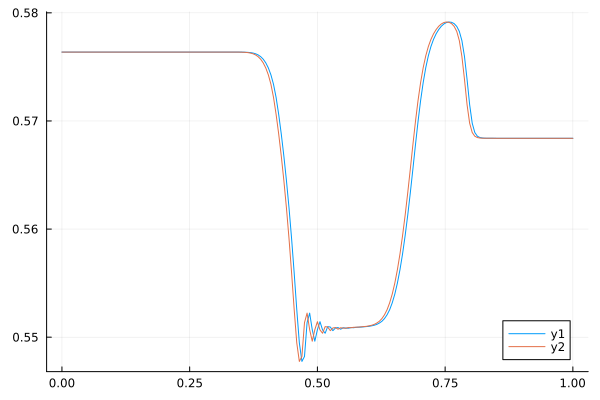

In [19]:
x_2 = LinRange(0,L,N-1)
plot(x_2,SSL)
plot!(x_2,SSR)

In [20]:
D_final = [U[i][1] for i in 1:N]

p_final = [pressure_nu(U[i])[1] for i in 1:N]

v_final = [pressure_nu(U[i])[2] for i in 1:N]

e_final = [pressure_nu(U[i])[3] for i in 1:N];

In [21]:
p_final;

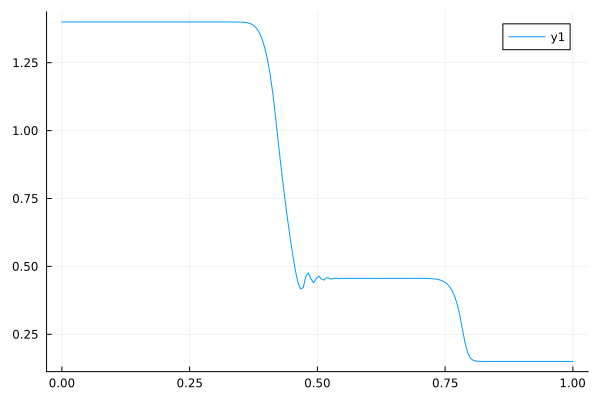

In [22]:
plot(x,p_final)

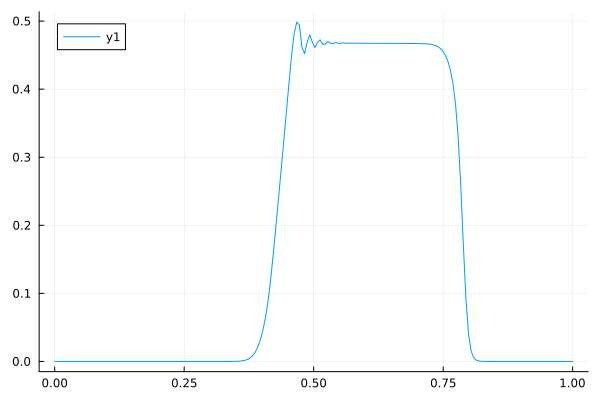

In [23]:
plot(x,v_final)

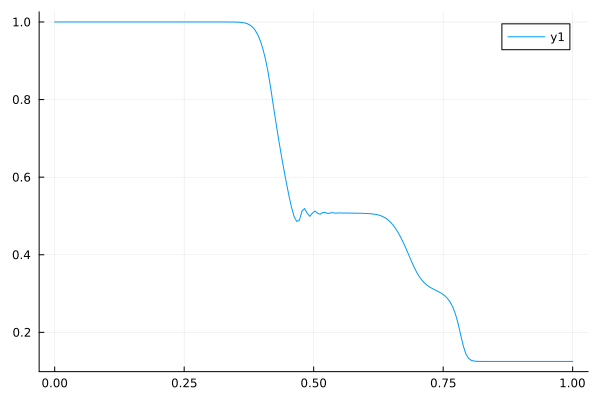

In [24]:
plot(x,D_final)

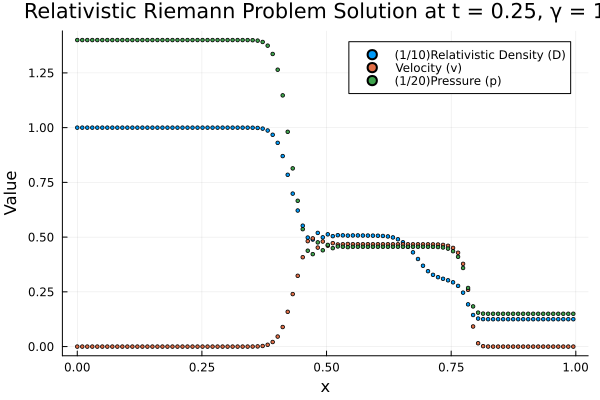

In [25]:
scatter(x[1:2:end], D_final[1:2:end], label="(1/10)Relativistic Density (D)", xlabel="x", ylabel="Value", title="Relativistic Riemann Problem Solution at t = $T, γ = $γ", markersize=2)
scatter!(x[1:2:end], v_final[1:2:end], label="Velocity (v)", markersize=2)
scatter!(x[1:2:end], p_final[1:2:end], label="(1/20)Pressure (p)", markersize=2)

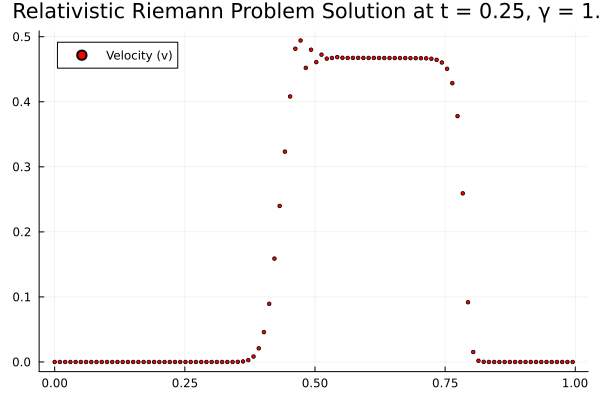

In [26]:
scatter(x[1:2:end], v_final[1:2:end], label="Velocity (v)", markersize=2,title="Relativistic Riemann Problem Solution at t = $T, γ = $γ",color=:red)

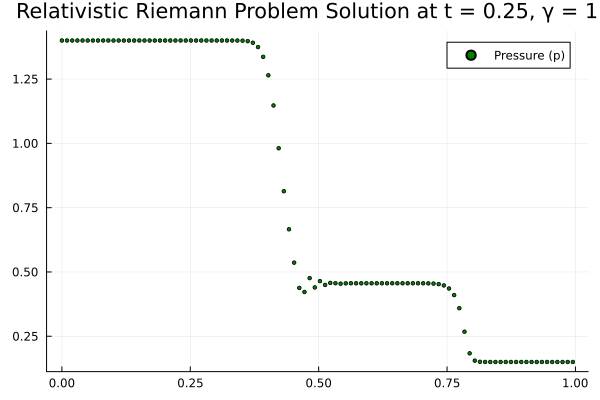

In [27]:
scatter(x[1:2:end], p_final[1:2:end], label="Pressure (p)", markersize=2,title="Relativistic Riemann Problem Solution at t = $T, γ = $γ",color=:green)

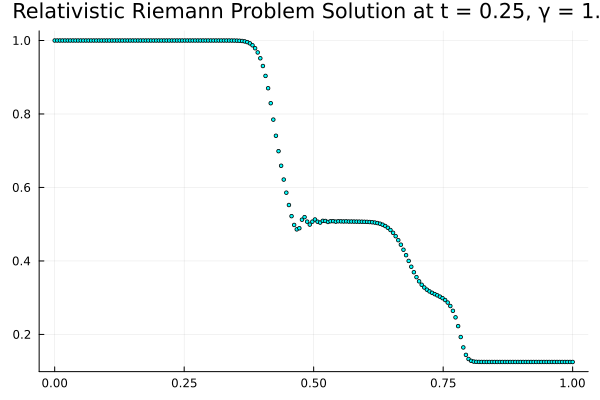

In [28]:
scatter(x[1:1:end], D_final[1:1:end], label="", markersize=2,title="Relativistic Riemann Problem Solution at t = $T, γ = $γ",color=:cyan)

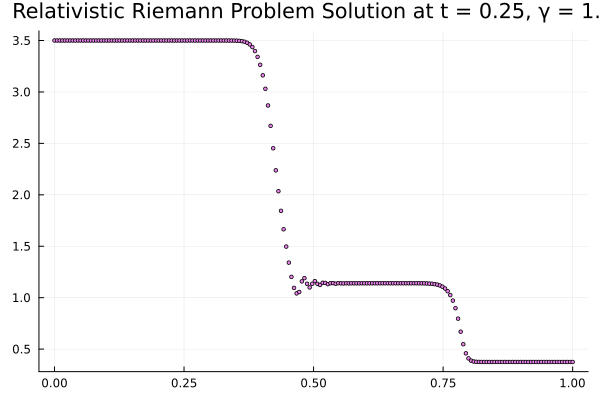

In [29]:
scatter(x[1:1:end], e_final[1:1:end], label="", markersize=2,title="Relativistic Riemann Problem Solution at t = $T, γ = $γ",color=:violet)

In [30]:
"""
using Plots
using Roots

# Parameters
γ = 1.4  # Adiabatic index for relativistic gas 5/3 , 4/3 , 1.999
c = 1.0  # Speed of light (set to 1 for simplicity)
N = 500  # Number of grid points
L = 1.0  # Domain length
dx = L / N  # Grid spacing
dt = 0.001  # Time step
T = 0.25  # Total simulation time
CFL = 0.9;  # CFL condition

# Initial condition for relativistic Riemann problem
function initial_condition(x)
    if x < 0.5
        ρ =  1.0  # Rest-mass density on the left  1.0, 10.0,2.0
        v =  0.0   # Velocity on the left
        p =  1.0  # Pressure on the left   1.0, 40.0/3 ,1990
    else
        ρ =  0.125  # Rest-mass density on the right 1.0,0.125,1.0
        v =  0.0    # Velocity on the right
        p =  0.1   # Pressure on the right 0.00001*(2/3) , 0.1 , 995
    end
    W = 1 / sqrt(1 - v^2)  # Lorentz factor
    h = 1 + (γ * p) / ((γ - 1) * ρ)  # Specific enthalpy
    D = ρ * W  # Relativistic mass density
    S = ρ * h * W^2 * v  # Momentum density
    E = ρ * h * W^2 - p   # Energy density
    return [D, S, E]
end

x1 = 0.8
print(initial_condition(x1))

function pressure_nu(U)
    D, S, E = U 
    function g(v)
        return ((v * E - S) + (γ - 1) * S * (1 - v^2)*(1 / γ))^2
    end
    # Debugging: Print the function values over the interval
    for v in LinRange(0, 1, 10)
        println("v = $v, g(v) = $(g(v))")
    end
    # Try finding the root with an initial guess
    vr = find_zero(g, 0.5)  # Initial guess of 0.5
    e = E - vr*S
    p = (γ - 1)*(E - vr*S)
    return [p, vr, e]
end

print(pressure_nu(initial_condition(x1)))
pressure_nu(initial_condition(x1))

function flux(U)
    D, S, E = U
    p = pressure_nu(U)[1]  # Pressure
    v = pressure_nu(U)[2]
    return [v * D, v * S + p, (p + E) * v]
end

flux(initial_condition(x1))

function relativistic_hlle_flux(U_L, U_R)
    p_L = pressure_nu(U_L)[1]
    p_R = pressure_nu(U_R)[1]
    
    c_s_L = sqrt(γ * p_L / (U_L[1] + (γ/(γ-1))*p_L))
    c_s_R = sqrt(γ * p_R / (U_R[1] + (γ/(γ-1))*p_R))
    
    v_L = pressure_nu(U_L)[2]
    v_R = pressure_nu(U_R)[2]
    
    λ_L = min(0, (v_L - c_s_L) / (1 - v_L * c_s_L), (v_R - c_s_R) / (1 - v_R * c_s_R))
    λ_R = max(0, (v_L + c_s_L) / (1 + v_L * c_s_L), (v_R + c_s_R) / (1 + v_R * c_s_R))
    
    F_L = flux(U_L)
    F_R = flux(U_R)
    
    if λ_L >= 0
        return F_L
    elseif λ_R <= 0
        return F_R
    else
        return (λ_R * F_L - λ_L * F_R + λ_L * λ_R * (U_R - U_L)) / (λ_R - λ_L)
    end
end

x = LinRange(0, L, N)
U = [initial_condition(xi) for xi in x]
U_new = deepcopy(U)

relativistic_hlle_flux(U[250], U[251])
"""

LoadError: UndefVarError: `v` not defined